## Spam Email Classification 
BAX452 Machine Learning Individual Project

Lisa Bai

### 1. Description

This project wants to build a machine-learning model for spam email classification. 

The dataset was collected at Iowa State University (ISU) in 2003. The student volunteers monitored their emails for a week and recorded information about each email message; for example, whether it was spam, and what day of the week and time of day the email arrived. We can use this information to build a spam filter, a classifier that will catch spam with high probability but will never classify good emails as spam.

Variables dictionary<br/>
- Isuid: ISU student id
- Id: email id (a unique message descriptor)
- Day of week: sum, mon, tue, wed, thu, fri, sat
- Time of day: 0-23 (only integer values)
- Size_kb: size of email in kilobytes
- Box: yes if sender is in the recipient's in- or outboxes (known to recipient); else no
- Domain: high-level domain of sender's email address
- Local: yes if sender's email is in local domain, else no
- Digits: number of numbers (0-9) in the sender's user name 
- Name: "full" if first and last names are present, "single" if only one name is present, or 'empty'
- Capct: % capital letters in subject line
- Special: number of non-alphanumeric characters in subject
- Credit: yes if subject line includes one of mortgage, sale, approve, credit; else no
- Sucker: yes if subject line includes one of the words earn, free, save; else no
- Porn : yes if subject line includes one of nude, sex, enlarge, improve; else no
- Chain: yes if subject line includes one of the words pass, forward, help; else no
- Username: yes if subject includes recipient's name or login; else no
- Large.text: yes if email is HTML and includes test for large font; else no
- Spampct: probability of being spam, according to ISU spam filter
- Category: extended spam/mail category: "com", "list", "news", "ord"
- Spam: yes if spam; else no

Data source: http://www.ggobi.org/book/

### 2. Import Python Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

### 3. Load Data 

In [2]:
email = pd.read_csv('/Users/liqiongbai/Downloads/spam.csv'); email.head()

,isuid,id,day of week,time of day,size.kb,box,domain,local,digits,name,...,special,credit,sucker,porn,chain,userfull,large text,spampct,category,spam
0,1,1,Thu,0,7,no,com,no,0,full,...,1,no,no,no,no,no,no,NaN,news,no
1,1,2,Thu,0,2,no,com,no,0,full,...,5,no,no,no,no,no,no,NaN,com,yes
2,1,3,Thu,14,3,no,edu,yes,0,full,...,2,no,no,no,yes,no,no,13.0,list,no
3,1,4,Thu,3,3,yes,de,no,0,full,...,0,no,no,no,no,no,no,NaN,ord,no
4,1,5,Thu,3,4,no,uk,no,0,full,...,2,no,no,no,no,no,no,NaN,list,no


In [3]:
email.shape

(2171, 21)

In [4]:
## Rename some columns for easy understanding
new_columns_names = ['student_id','email_id','day_of_week','time_of_day','size_kb','known_to_recipient','domain',
                     'local','digits','name_presented','capital_percent','special_char','credit','sucker','porn',
                     'chain','username','large_text','spam_prob','category','spam']
email = email.rename(columns=dict(zip(email.columns, new_columns_names)))
email.head()

,student_id,email_id,day_of_week,time_of_day,size_kb,known_to_recipient,domain,local,digits,name_presented,...,special_char,credit,sucker,porn,chain,username,large_text,spam_prob,category,spam
0,1,1,Thu,0,7,no,com,no,0,full,...,1,no,no,no,no,no,no,NaN,news,no
1,1,2,Thu,0,2,no,com,no,0,full,...,5,no,no,no,no,no,no,NaN,com,yes
2,1,3,Thu,14,3,no,edu,yes,0,full,...,2,no,no,no,yes,no,no,13.0,list,no
3,1,4,Thu,3,3,yes,de,no,0,full,...,0,no,no,no,no,no,no,NaN,ord,no
4,1,5,Thu,3,4,no,uk,no,0,full,...,2,no,no,no,no,no,no,NaN,list,no


In [5]:
## Check missing values
email.isnull().sum()

student_id               0
email_id                 0
day_of_week              0
time_of_day              0
size_kb                  0
known_to_recipient       0
domain                   0
local                    0
digits                   0
name_presented           0
capital_percent          0
special_char             0
credit                   0
sucker                   0
porn                     0
chain                    0
username                 0
large_text               0
spam_prob             1353
category                 0
spam                     0
dtype: int64

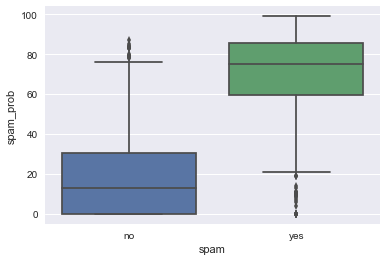

In [6]:
## Check the variable of "spam probability" which has over 50% missing values
ax = sns.boxplot(x="spam", y="spam_prob", data=email)

In [7]:
## Remove the columns of 'student_id', 'email_id' and 'spam_prob' 
email = email.drop(['student_id', 'email_id', 'spam_prob'], axis=1)

In [8]:
email.shape

(2171, 18)

Brief summary:
1. The dataset provided by ISU is very clean with only one column has missing values.
2. Remove the column of "spam_prob" since it is according to a spam filter and only provides very limited values.
3. Also remove "student_id" and "email_id" which have no effect on the target variable.

### 4. EDA & Feature Selection

#### 4.1 Check each variable

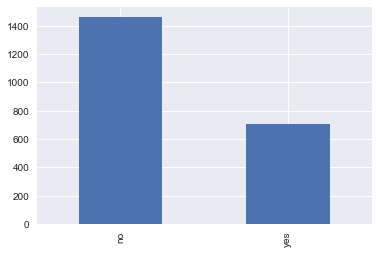

In [9]:
## Check target variable "spam or not"
email['spam'].value_counts().plot(kind='bar')

The balance of class distribution is acceptable.

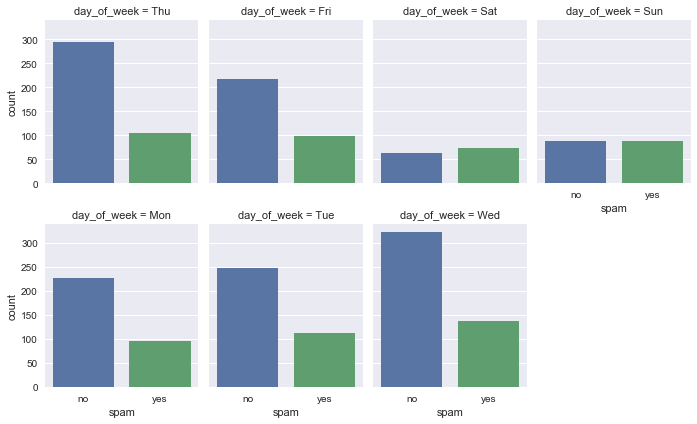

In [10]:
## Check feature "day_of_work"
ax = sns.factorplot(x="spam", col="day_of_week", col_wrap=4, data=email, kind="count", size=3, aspect=.8)

The percentage of spam is higher on weekends than weekdays.

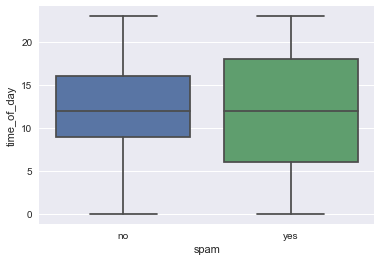

In [11]:
## Check feature "time_of_day"
ax = sns.boxplot(x="spam", y="time_of_day", data=email)  

The proability of getting spam emails is higher at off-work time.

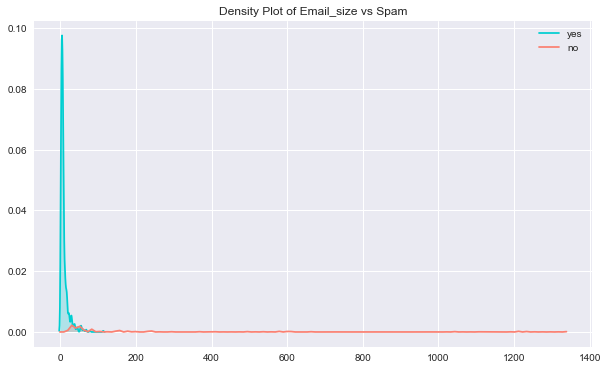

In [12]:
## Checking feature "email size"
plt.figure(figsize=(10,6))
sns.kdeplot(email["size_kb"][email.spam == "yes"], color="darkturquoise", shade=True)
sns.kdeplot(email["size_kb"][email.spam == "no"], color="salmon", shade=True)
plt.legend(['yes', 'no'])
plt.title('Density Plot of Email_size vs Spam')
plt.show()    

Emails with size more than 100 kilobytes are usually not spam.

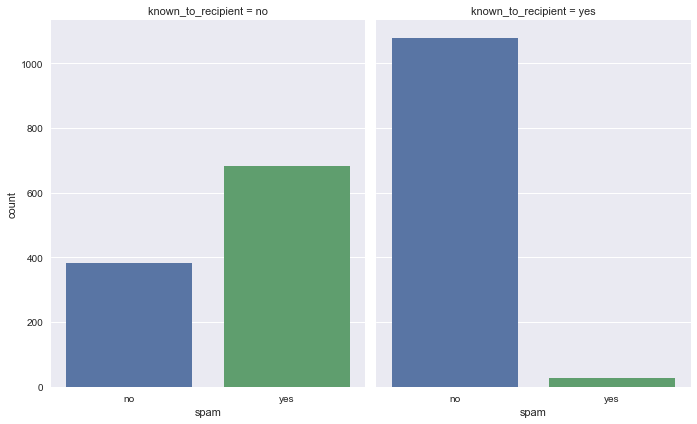

In [13]:
## Check variable "if the recipient knows the sender"
ax = sns.factorplot(x="spam", col="known_to_recipient", data=email, kind="count", size=6, aspect=.8)

It is more likely not a spam email if the sender's email address has been kept in the recipient's mail box.

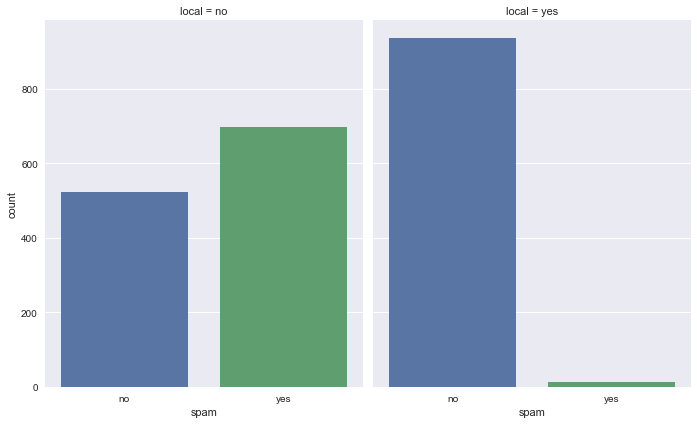

In [14]:
## Check feature "if sender's email is in local domain"
ax = sns.factorplot(x="spam", col="local", data=email, kind="count", size=6, aspect=.8)

It's usually not a spam email if the sender's email is in local domain.

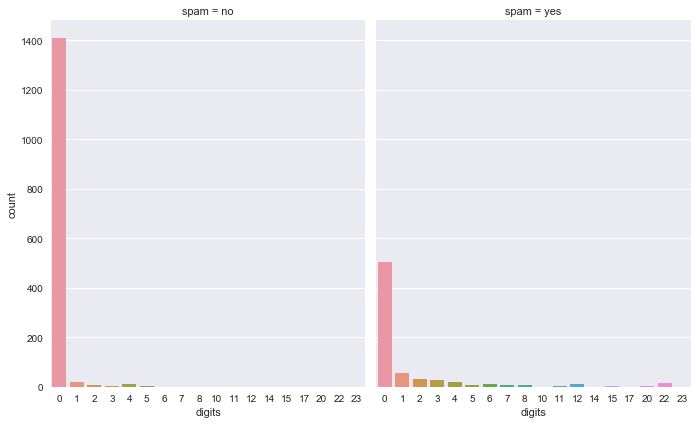

In [15]:
## Check feature "numbers in the sender's user name"
ax = sns.factorplot(x="digits", col="spam", data=email, kind="count", size=6, aspect=.8)

It tends to be a spam email if the sender's username has many numbers. 

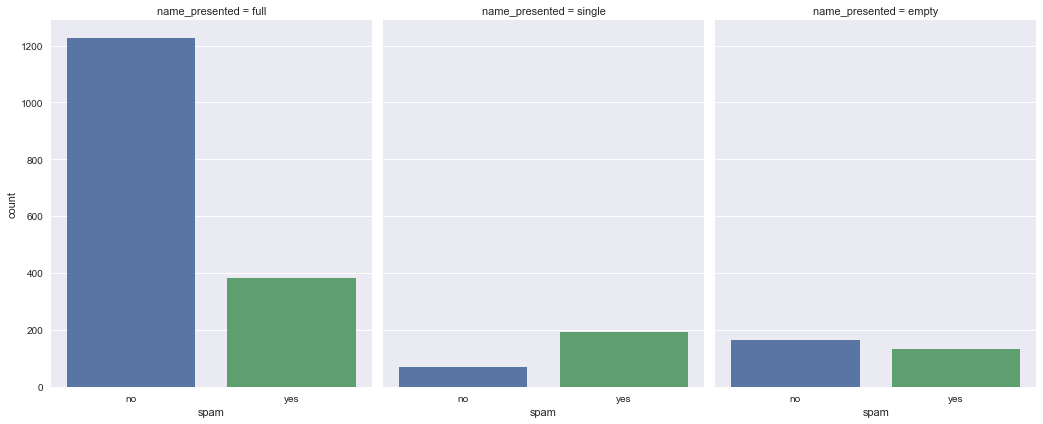

In [16]:
## Check feature "name presented"
ax = sns.factorplot(x="spam", col="name_presented", data=email, kind="count", size=6, aspect=.8)

It is more likely to be spam if the email doesn't presents the sender's full name.

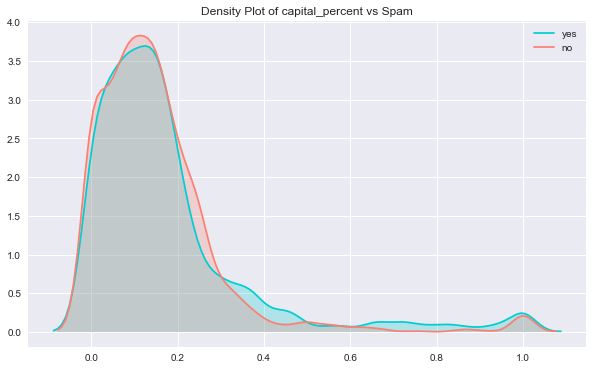

In [17]:
## Check feature "percentage of capital letters in subject line"
plt.figure(figsize=(10,6))
sns.kdeplot(email["capital_percent"][email.spam == "yes"], color="darkturquoise", shade=True)
sns.kdeplot(email["capital_percent"][email.spam == "no"], color="salmon", shade=True)
plt.legend(['yes', 'no'])
plt.title('Density Plot of capital_percent vs Spam')
plt.show()    

"capital_percent" doesn't seem a remarkable feature. 

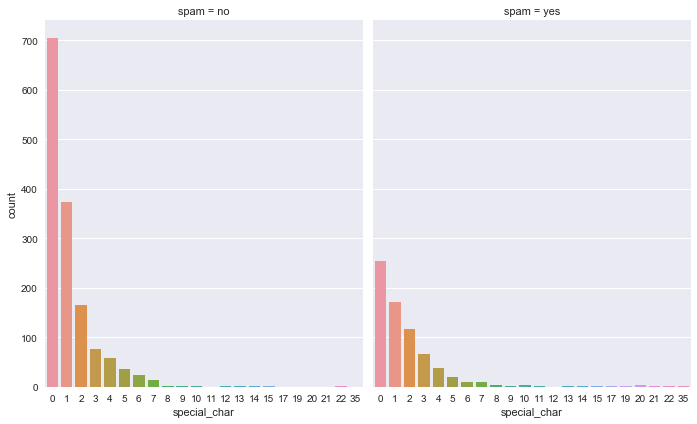

In [18]:
## check feature "number of non-alphanumeric characters in subject"
ax = sns.factorplot(x="special_char", col="spam", data=email, kind="count", size=6, aspect=.8)

 "special_char" doesn't seem a remarkable feature. 

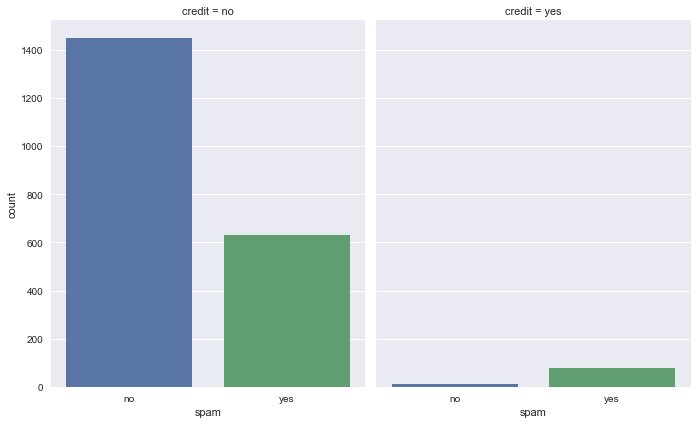

In [19]:
## Check feature "if subject line includes one of mortgage, sale, approve, credit"
ax = sns.factorplot(x="spam", col="credit", data=email, kind="count", size=6, aspect=.8)

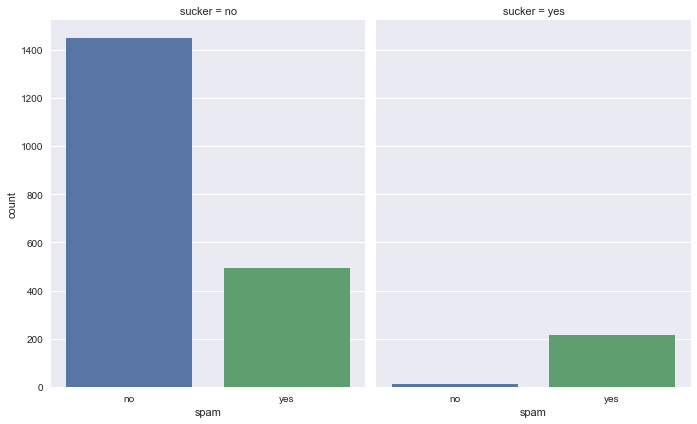

In [20]:
## Check feature "if subject line includes one of the words earn, free, save"
ax = sns.factorplot(x="spam", col="sucker", data=email, kind="count", size=6, aspect=.8)

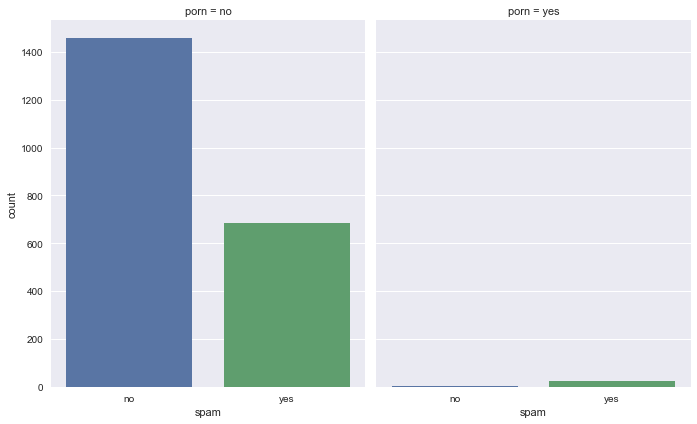

In [21]:
## Check feature "if subject line includes one of the words nude, sex, enlarge, improve"
ax = sns.factorplot(x="spam", col="porn", data=email, kind="count", size=6, aspect=.8)

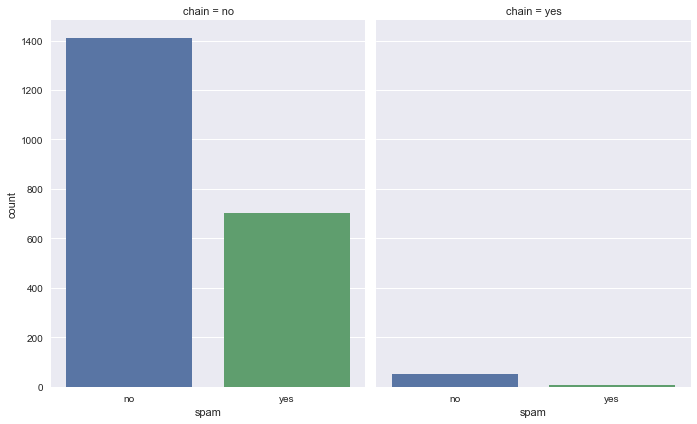

In [22]:
## Check feature "if subject line includes one of the words pass, forward, help"
ax = sns.factorplot(x="spam", col="chain", data=email, kind="count", size=6, aspect=.8)

- It is more likely to be spam if subject line includes one of the words related to "credit", "sucker" and "porn".
- No significant influence if subject line includes one of the words related to "chain"


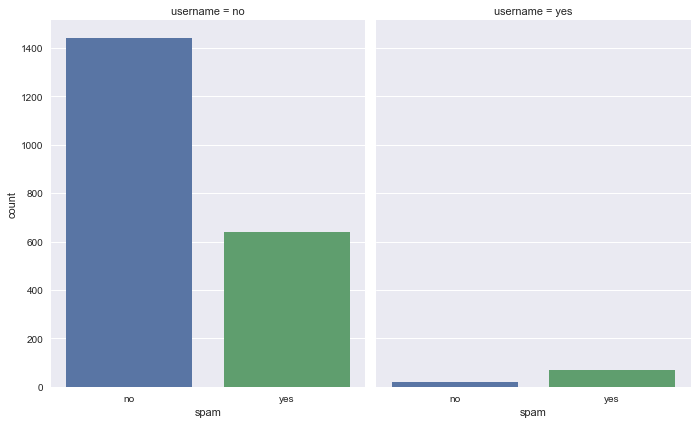

In [23]:
## Check feature "if subject includes recipient's name or login"
ax = sns.factorplot(x="spam", col="username", data=email, kind="count", size=6, aspect=.8)

It is more likely to be spam if subject includes recipient's name or login.

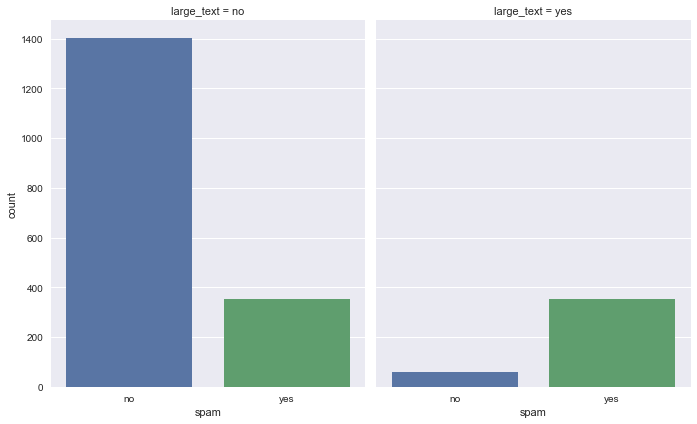

In [24]:
## Check feature "if email is HTML and includes test for large font"
ax = sns.factorplot(x="spam", col="large_text", data=email, kind="count", size=6, aspect=.8)

It is more likely to be spam if email is HTML and includes test for large font

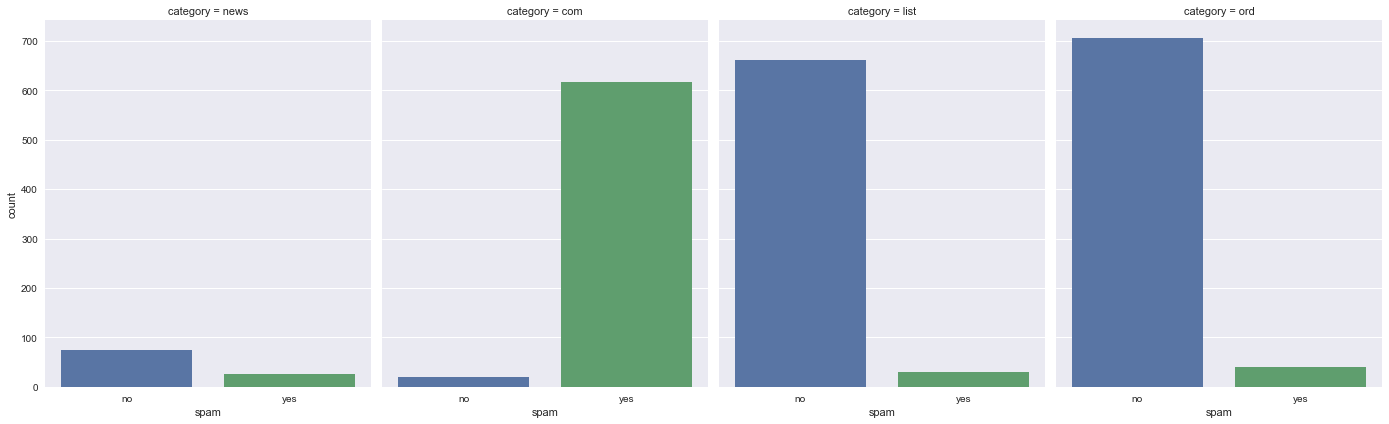

In [25]:
## Check feature "category"
ax = sns.factorplot(x="spam", col="category", data=email, kind="count", size=6, aspect=.8)

It is more likely to be spam if the email category comes with 'com'.

#### 4.2 Dataset Preparation

In [26]:
## prepare modeling dataset
email.dtypes

day_of_week            object
time_of_day             int64
size_kb                 int64
known_to_recipient     object
domain                 object
local                  object
digits                  int64
name_presented         object
capital_percent       float64
special_char            int64
credit                 object
sucker                 object
porn                   object
chain                  object
username               object
large_text             object
category               object
spam                   object
dtype: object

In [27]:
## change all 'yes' to 1 and 'no' to 0
email = email.replace(['yes', 'no'], [1, 0])
#email.head(3)

In [28]:
email['day_of_week'].unique(), email['domain'].unique(), email['name_presented'].unique(), email['category'].unique()

(array(['Thu', 'Fri', 'Sat', 'Sun', 'Mon', 'Tue', 'Wed'], dtype=object),
 array(['com', 'edu', 'de', 'uk', 'be', 'se', 'ch', 'ca', 'nz', 'hu', 'cy',
        'kw', 'net', 'org', 'at', 'fr', 'gov', 'ph', 'cz', 'ro', 'tw', 'by',
        'cn', 'info', 'pt', 'pl', 'it', 'lv', 'us', 'pin', 'lt', 'kr', 'sk',
        'co', 'rdp', 'bak', 'hfc', 'hkd', 'tsp', 'is', 'il', 'c', 'jp', 'my'], dtype=object),
 array(['full', 'single', 'empty'], dtype=object),
 array(['news', 'com', 'list', 'ord'], dtype=object))

In [29]:
#email.domain.value_counts()

In [30]:
def num(email):
    if email['domain'] == 'edu':
        return 3
    elif email['domain'] == 'com':
        return 2
    elif email['domain'] == 'net':
        return 1
    else:
        return 0
    
email['domain'] = email.apply(num, axis=1)

In [31]:
email.domain.value_counts()

3    1037
2     807
0     209
1     118
Name: domain, dtype: int64

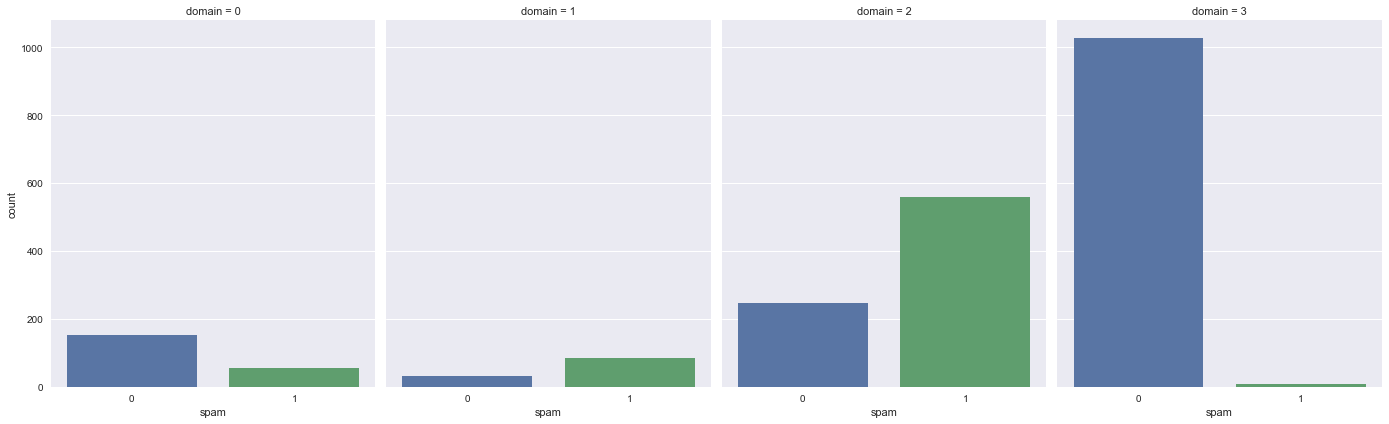

In [32]:
## Check feature "domain"
ax = sns.factorplot(x="spam", col="domain", data=email, kind="count", size=6, aspect=.8)

In [33]:
## Covert categorical variables into numbers
le = preprocessing.LabelEncoder()
email.category = le.fit_transform(email.category)
email['day_of_week'] = email['day_of_week'].map({'Mon': 1, 'Tue' : 2, 'Wed' : 3, 'Thu': 4, 'Fri': 5, 'Sat': 6, 'Sun': 7}).astype(int)
email['name_presented'] = email['name_presented'].map({'full':2, 'single':1, 'empty':0})
email.head(3)

,day_of_week,time_of_day,size_kb,known_to_recipient,domain,local,digits,name_presented,capital_percent,special_char,credit,sucker,porn,chain,username,large_text,category,spam
0,4,0,7,0,2,0,0,2,0.193548,1,0,0,0,0,0,0,2,0
1,4,0,2,0,2,0,0,2,0.191489,5,0,0,0,0,0,0,0,1
2,4,14,3,0,3,1,0,2,0.074074,2,0,0,0,1,0,0,1,0


#### 4.3 Check Correlation & Select Features

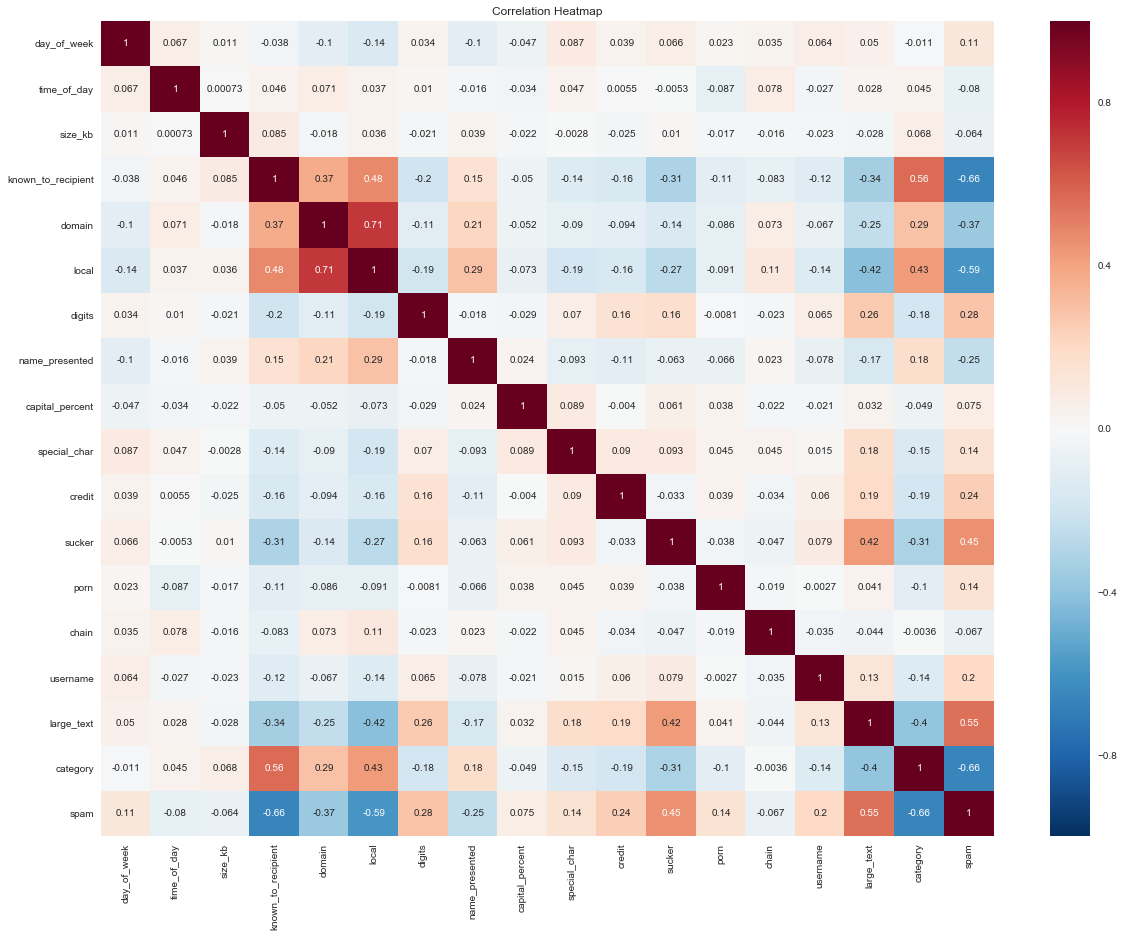

In [34]:
## correlation heatmap
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title("Correlation Heatmap")
corr = email.corr()
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [35]:
## email.groupby('spam').mean()

Berief summary:<br>
- Insignificant features: "capital_percent", "special_char" and "chain"
- Redundant features: "domain" and "local"

### 5. Modeling

#### 5.1 Iterate Several Classifiers Using All Features

In [47]:
email.shape

(2171, 18)

In [43]:
## Split training and testing data set
X = email.drop('spam', axis=1); y = email['spam']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=21, stratify = y)

In [44]:
import pandas as pd

classifiers = {
    'Logistic Regression': LogisticRegression(),
    'kNN': KNeighborsClassifier(n_neighbors=20),
    'Decision Tree': DecisionTreeClassifier(max_depth=5),
    'SVCrbf': SVC(kernel='rbf'),
    'SVCpoly': SVC(kernel='poly', degree=1),
    'linSVC1': SVC(kernel="linear"),
    'linSVC2': LinearSVC(),
    'Random Forest': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    'AdaBoost': AdaBoostClassifier(n_estimators=10),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), max_iter=2000),
    'Naive Bayes': GaussianNB(),
    'QDA': QuadraticDiscriminantAnalysis(),
}

scores = {}
for clf_name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_pred, y_test)
    scores[clf_name] = score
    
models = pd.DataFrame(list(scores.items()))
models.columns = ['Model', 'Score']
models.sort_values(by='Score', ascending=False)

,Model,Score
2,Decision Tree,0.973926
4,SVCpoly,0.967791
8,AdaBoost,0.966258
0,Logistic Regression,0.964724
5,linSVC1,0.964724
9,Neural Network,0.964724
6,linSVC2,0.957055
7,Random Forest,0.926380
3,SVCrbf,0.923313
10,Naive Bayes,0.918712


#### 5.2 Iterate Same Classifiers Using Selected Features

In [48]:
## Remove insignificant features
email_final = email.drop(['capital_percent', 'special_char', 'chain'], axis=1)
#email_final.head()
email_final.shape

(2171, 15)

In [49]:
## Split training and testing data set
X1 = email_final.drop('spam', axis=1); y1 = email_final['spam']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.3, random_state=21, stratify = y)

In [51]:
scores = {}
for clf_name, clf in classifiers.items():
    clf.fit(X1_train, y1_train)
    y1_pred = clf.predict(X1_test)
    score = accuracy_score(y1_pred, y1_test)
    scores[clf_name] = score
    
models = pd.DataFrame(list(scores.items()))
models.columns = ['Model', 'Score']
models.sort_values(by='Score', ascending=False)

,Model,Score
2,Decision Tree,0.975460
7,Random Forest,0.969325
9,Neural Network,0.969325
4,SVCpoly,0.967791
5,linSVC1,0.966258
0,Logistic Regression,0.964724
8,AdaBoost,0.963190
3,SVCrbf,0.955521
6,linSVC2,0.955521
10,Naive Bayes,0.914110


Brief summary:<br>
- Removing insignificant variables results in slight differnence on accuracy. Not always improve the results. But the training process can be much faster as the input is less. So we can still say that the feature selection is efficient.

- Decision Tree classifier would be the final choice. 

### 6. Champion Model Selection - Decision Tree Classifier

In [52]:
clf = DecisionTreeClassifier(max_depth=5)
clf = clf.fit(X1_train, y1_train)
#y1_pred = clf.predict(X1_test)
#accuracy_score(y1_pred, y1_test)

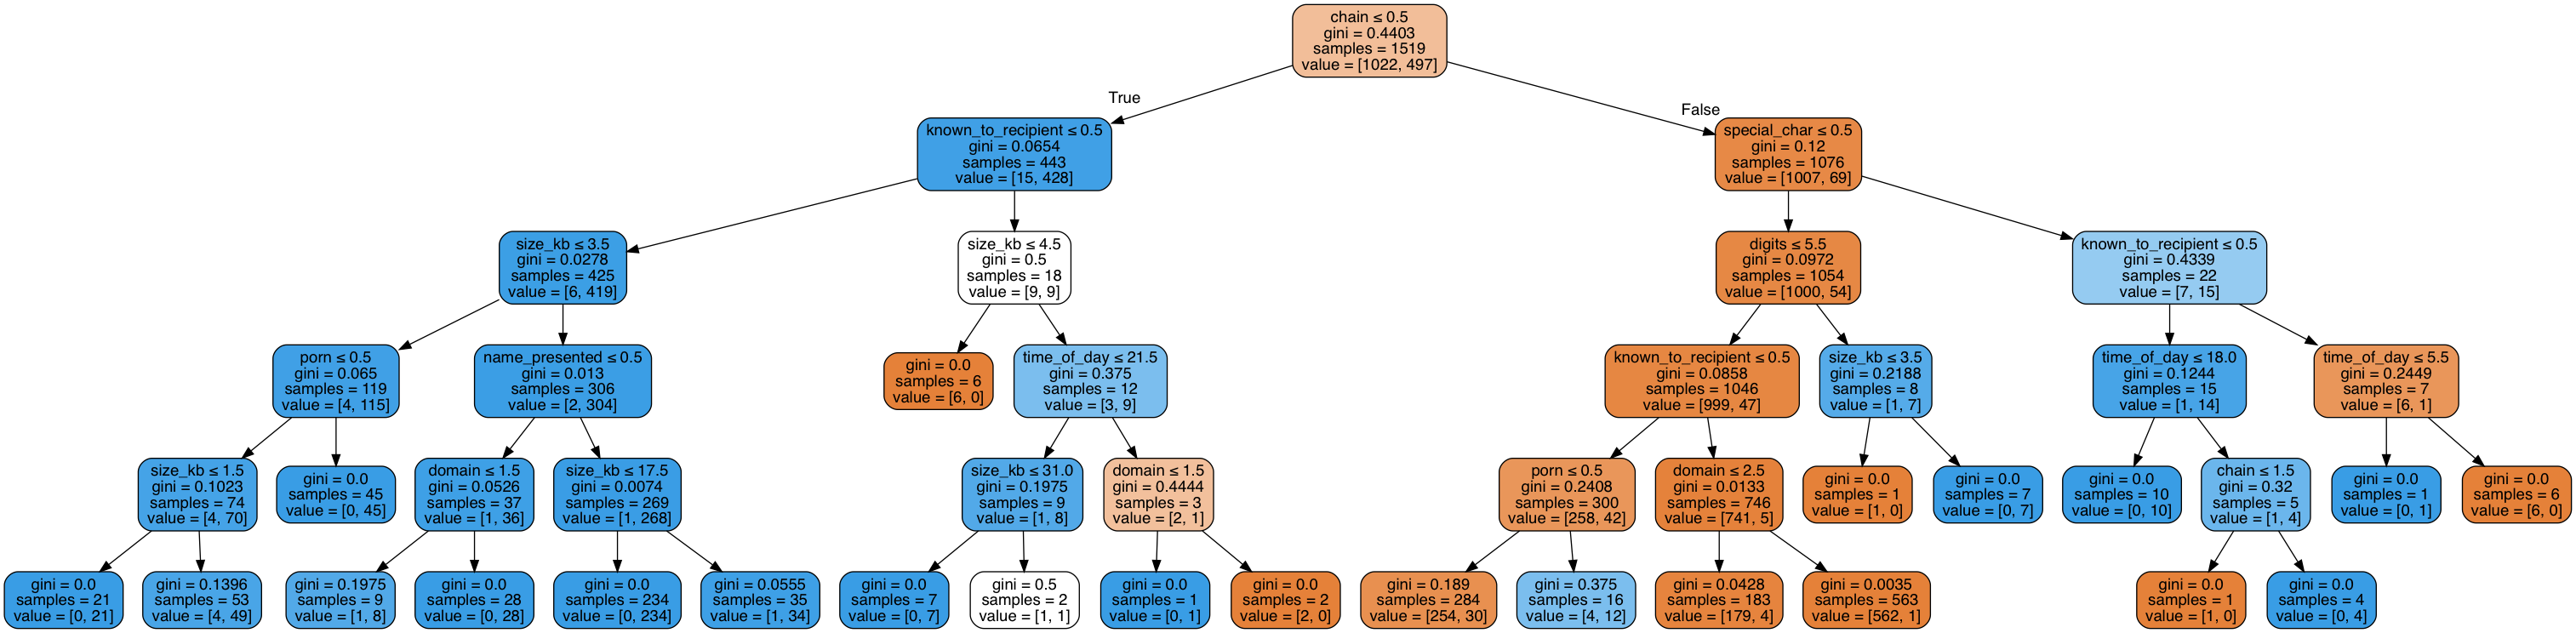

In [53]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, 
                feature_names = X.columns.values,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

### 7. Takeaways & Tradeoffs

Takeaways:
- EDA process usually follows our intuition and confirms our guess.
- Need to try a lot to get the optimal result.

Tradeoffs:
- This data set was extracted over 10 years ago and spammers evolve their attacks quickly, some recognizable signs of spam no longer exist now.
- This data set is not big, and definitely we will need more complex algorithms or multi-stage solutions over large scale data set to detect spam emails.